# Dogs and Cats Redux

Competition Link: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
%pwd

u'/home/ubuntu/kaggle/dogs-vs-cats-redux'

In [20]:
#Create references to important directories
import os, sys
from glob import glob
import numpy as np
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

In [5]:
#Allow relative imports to directories above this folder
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#Inline plotting tool
%matplotlib inline

#import modules
from utils import *
from utils.vgg16 import Vgg16


Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [50]:
#Need to correctly import utils.py
import bcolz 
from numpy.random import random, permutation

## Create Results Folder

In [6]:
%cd $DATA_HOME_DIR

/home/ubuntu/kaggle/dogs-vs-cats-redux/data


In [7]:
#Create directories
%mkdir results
%mkdir valid
%mkdir -p test/unknown

In [22]:
#Move a sample size into the valid folder
%cd $DATA_HOME_DIR/train

g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

/home/ubuntu/kaggle/dogs-vs-cats-redux/data/train


## Move images to respective categorical directories

In [23]:
%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/kaggle/dogs-vs-cats-redux/data/valid
/home/ubuntu/kaggle/dogs-vs-cats-redux/data/train


In [33]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/kaggle/dogs-vs-cats-redux/data/test


## Finetuning and Training

In [65]:
%cd $DATA_HOME_DIR

path = DATA_HOME_DIR + '/'
test_path = DATA_HOME_DIR + '/test/' 
results_path=DATA_HOME_DIR + '/results/'
train_path=DATA_HOME_DIR + '/train/'
valid_path=DATA_HOME_DIR + '/valid/'

/home/ubuntu/kaggle/dogs-vs-cats-redux/data


In [27]:
#import Vgg16 helper class
vgg = Vgg16()

In [28]:
#Set constants
batch_size=64
no_of_epochs=5

In [29]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Set the learning rate
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [30]:
#Passing in the validation dataset to the fit() method
#For each epoch, test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 651s - loss: 0.3584 - acc: 0.9685 - val_loss: 0.2308 - val_acc: 0.9805
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 653s - loss: 0.3027 - acc: 0.9780 - val_loss: 0.2842 - val_acc: 0.9795
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 653s - loss: 0.3332 - acc: 0.9767 - val_loss: 0.2614 - val_acc: 0.9800
Running epoch: 3
Epoch 1/1
23000/23000 [==============================] - 653s - loss: 0.3244 - acc: 0.9773 - val_loss: 0.2292 - val_acc: 0.9845
Running epoch: 4
Epoch 1/1
23000/23000 [==============================] - 653s - loss: 0.3508 - acc: 0.9761 - val_loss: 0.1467 - val_acc: 0.9905
Completed 5 fit operations


## Generate Predictions

In [34]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [35]:
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


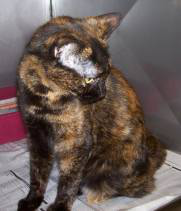

In [36]:
#Verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [95]:
from matplotlib import pyplot as plt

#Need to correctly import utils.py
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def load_array(fname):
    return bcolz.open(fname)[:]
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [46]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Inspect predictions on Validation Set

In [81]:
latest_weights_filename

'ft4.h5'

In [82]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [83]:
valid_path

'/home/ubuntu/kaggle/dogs-vs-cats-redux/data/valid/'

In [75]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [84]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs

#Our predictions to 0/1 to generate lables
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

#Expected labels
expected_labels = val_batches.classes #0 or 1
filenames = val_batches.filenames

In [85]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1972 correct labels


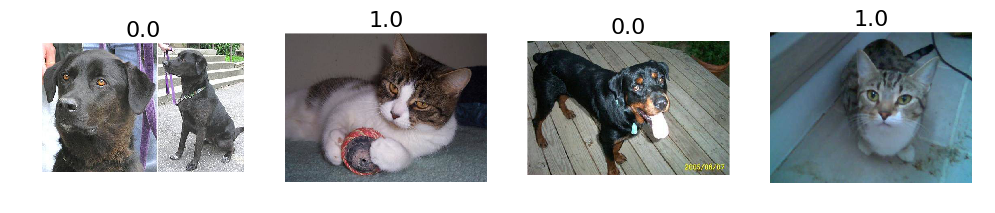

In [88]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 28 incorrect labels


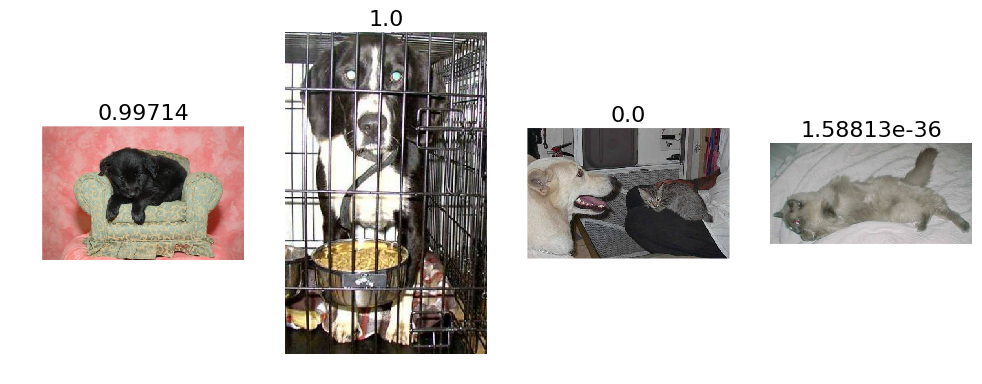

In [89]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 1004 confident correct cats labels


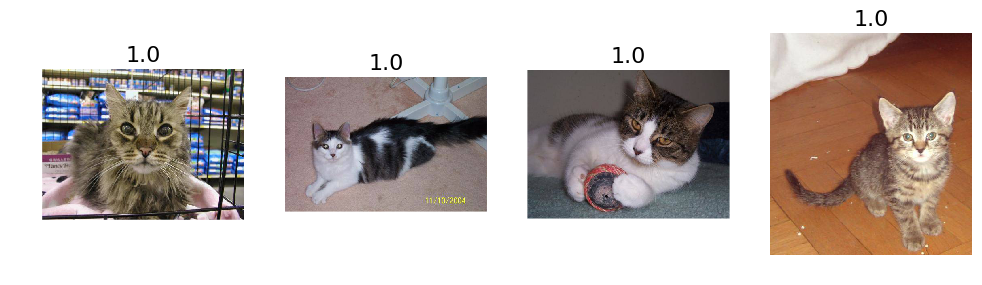

In [90]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 968 confident correct dogs labels


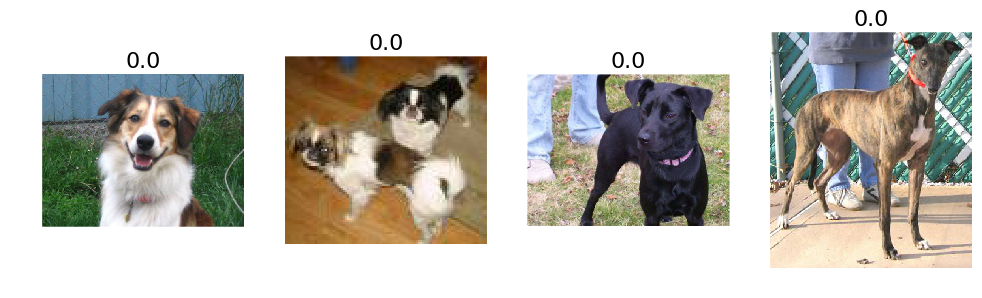

In [91]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 16 incorrect cats


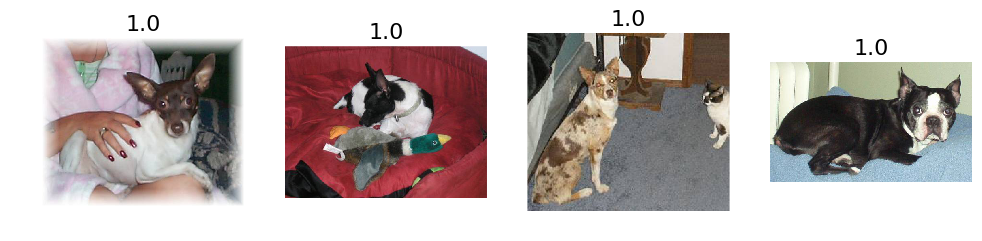

In [92]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 12 incorrect dogs


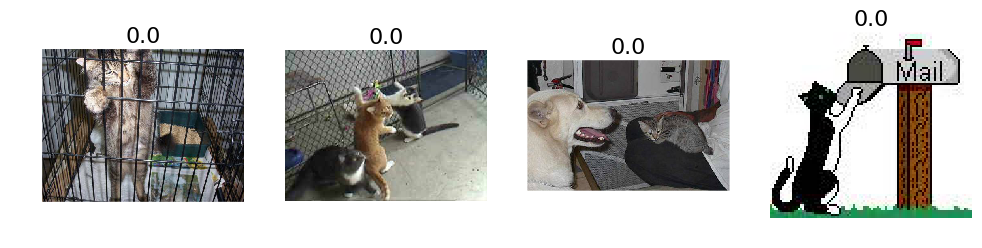

In [93]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

## Create submission file for Kaggle

Use te Log loss metric to evaluate the image of being a dog

Format:
imageId,isDog

In [96]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [97]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [ 0.  0.  0.  0.  1.]
Mid Predictions: [ 0.4270387   0.51890206]
Edge Predictions: [ 0.  0.  0. ...,  0.  0.  1.]


In [98]:
#Round down our edge predictions to avoid being penalized by Kaggle
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [99]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [100]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.29200000e+03,   5.00000007e-02],
       [  1.20260000e+04,   5.00000007e-02],
       [  9.68800000e+03,   5.00000007e-02],
       [  4.39200000e+03,   5.00000007e-02],
       [  7.79000000e+02,   9.49999988e-01]])

In [101]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission_1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/kaggle/dogs-vs-cats-redux/data


In [103]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/'+submission_file_name)

/home/ubuntu/kaggle/dogs-vs-cats-redux


/home/ubuntu/kaggle/dogs-vs-cats-redux/data/submission_1.csv